In [1]:
import os
import time
import skimage.io
import numpy as np
import pandas as pd
# import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm
import copy
from PIL import Image



In [2]:
data_dir = './PANDA_data/'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
df_sub = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

model_dir = './'
image_folder = os.path.join(data_dir, 'test_images')
is_test = os.path.exists(image_folder)  # IF test_images is not exists, we will use some train images.
image_folder = image_folder if is_test else os.path.join(data_dir, 'train_images')

df = df_test if is_test else df_train
# df = df_test if is_test else df_train[df_train['data_provider']=='karolinska'].loc[:100]
# df = df_test if is_test else df_train.loc[:100]
image_size = 256
batch_size = 8
num_workers = 8
out_dim = 6

gpu_id = 1
device = torch.device(f'cuda:{gpu_id}')

print(image_folder)

./PANDA_data/train_images


In [3]:
df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [4]:
crop_size=256
img_list=[]
for img_id in tqdm(df['image_id'].values):
    img=skimage.io.MultiImage(os.path.join(image_folder,img_id)+'.tiff')
    for i in range(img[1].shape[0]//crop_size+1):
        for j in range(img[1].shape[1]//crop_size+1):
            img_list.append(img_id+'_'+str(i)+'_'+str(j))
df_cropped=pd.DataFrame({'image_id':img_list})

100%|██████████| 10616/10616 [10:55<00:00, 16.20it/s]


In [5]:
df_cropped.head()

,image_id
0,0005f7aaab2800f6170c399693a96917_0_0
1,0005f7aaab2800f6170c399693a96917_0_1
2,0005f7aaab2800f6170c399693a96917_0_2
3,0005f7aaab2800f6170c399693a96917_0_3
4,0005f7aaab2800f6170c399693a96917_0_4


In [6]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x
#         return F.log_softmax(x,dim=0)
    
    
def load_models(model_files):
    models = []
    for model_f in model_files:
        model_f = os.path.join(model_dir, model_f)
        backbone = 'efficientnet-b0'
        model = enetv2(backbone, out_dim=out_dim)
        model.load_state_dict(torch.load(model_f, map_location=lambda storage, loc: storage), strict=True)
        model.eval()
        model.to(device)
        models.append(model)
        print(f'{model_f} loaded!')
    return models


model_files = [
    'efficient_base_256_best_fold0.pth'
]

models = load_models(model_files)

./efficient_base_256_best_fold0.pth loaded!


In [7]:
def padding_img(img_tmp):
        pad=crop_size-img_tmp.shape[0]
        pad=np.full((pad,img_tmp.shape[1],img_tmp.shape[2]),255)
        img_tmp=np.concatenate([img_tmp,pad],axis=0)
        pad=crop_size-img_tmp.shape[1]
        pad=np.full((img_tmp.shape[0],pad,img_tmp.shape[2]),255)
        img_tmp=np.concatenate([img_tmp,pad],axis=1)
        return img_tmp

In [8]:
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 crop_size,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.rand = rand
        self.transform = transform
        self.crop_size=crop_size
        self.image=None
        self.pre_img_id=None

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        i=int(img_id.split('_')[1])
        j=int(img_id.split('_')[2])
        img_id=img_id.split('_')[0]
        
        if img_id != self.pre_img_id:
            self.pre_img_id=img_id
            self.image=os.path.join(image_folder, img_id)
            self.image = skimage.io.MultiImage(os.path.join(image_folder, f'{img_id}.tiff'))[1]
        
        image=self.image[i*self.crop_size:(i+1)*self.crop_size,j*self.crop_size:(j+1)*self.crop_size,:]
#         print(np.count_nonzero(image==255))
        if image.shape[0]<self.crop_size or image.shape[1]<self.crop_size:
                image=padding_img(image)
        
        image=Image.fromarray(image.astype('uint8'))
        image=image.resize((self.image_size,self.image_size))
        image=np.asarray(image)
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        image = image.astype(np.float32)
        image /= 255
        image = image.transpose(2, 0, 1)

        return torch.tensor(image)



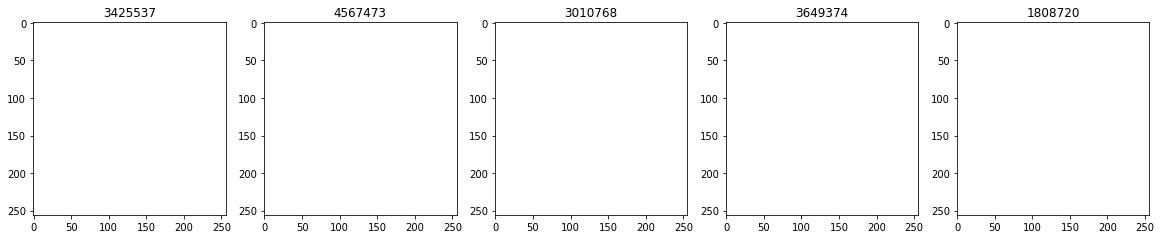

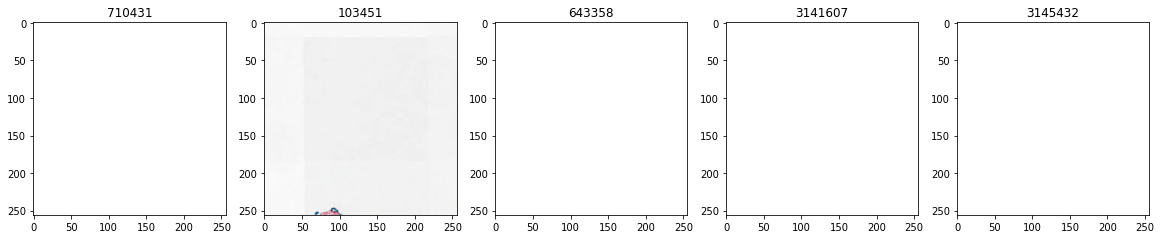

In [9]:
if not is_test:
    dataset_show = PANDADataset(df_cropped,image_size,crop_size)
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range(2):
        f, axarr = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img = dataset_show[idx]
            axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
            axarr[p].set_title(str(idx))

In [10]:
dataset = PANDADataset(df_cropped, image_size,crop_size)
loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [11]:
LOGITS = []
PREDS=[]
with torch.no_grad():
    for data in tqdm(loader):
        data = data.to(device)
        logits = models[0](data)
        LOGITS.append(logits)
        pred=logits.argmax(1).detach()
        PREDS.append(pred)

LOGITS = torch.cat(LOGITS).cpu().numpy()
PREDS = torch.cat(PREDS).cpu().numpy()

100%|██████████| 624549/624549 [3:30:30<00:00, 49.45it/s]  


In [12]:
uniq,cnt=np.unique(PREDS,return_counts=True)

In [13]:
uniq

array([0, 1, 2, 3, 4, 5])

In [14]:
cnt

array([4394594,   59855,  244952,   71278,  201562,   24151])

In [15]:
len(PREDS)

4996392

In [16]:
imgid=[imgid.split('_')[0] for imgid in df_cropped['image_id'].values]
idx1=[imgid.split('_')[1] for imgid in df_cropped['image_id'].values]
idx2=[imgid.split('_')[2] for imgid in df_cropped['image_id'].values]

In [17]:
tmp=pd.DataFrame({'image_id':imgid,
              'idx1':idx1,
              'idx2':idx2,
              'gleason':PREDS})

In [18]:
tmp.to_csv('pred_gleason_256.csv',index=False)

In [19]:
tmp

,image_id,idx1,idx2,gleason
0,0005f7aaab2800f6170c399693a96917,0,0,0
1,0005f7aaab2800f6170c399693a96917,0,1,0
2,0005f7aaab2800f6170c399693a96917,0,2,0
3,0005f7aaab2800f6170c399693a96917,0,3,0
4,0005f7aaab2800f6170c399693a96917,0,4,0
...,...,...,...,...
4996387,ffe9bcababc858e04840669e788065a1,30,2,0
4996388,ffe9bcababc858e04840669e788065a1,30,3,0
4996389,ffe9bcababc858e04840669e788065a1,30,4,0
4996390,ffe9bcababc858e04840669e788065a1,30,5,0


In [20]:
# pre_img_id=None
# predict=[]
# res=[]
# id_list=[]
# for img_id,pred in tqdm(zip(df_cropped['image_id'],LOGITS)):
#     if pre_img_id!=img_id.split('_')[0]:
#         if pre_img_id is not None:
#             predict.append(res)
#         res=pred
#         pre_img_id=img_id.split('_')[0]
#         id_list.append(pre_img_id)
        
#     res+=pred
    
# predict.append(res)

In [21]:
# tmp=pd.DataFrame(predict,columns=(['Gleason '+str(i) for i in range(0,6)]))
# pd.concat([df.reset_index(drop=True)[['image_id','isup_grade']],tmp],axis=1).to_csv('pred_isupgrade.csv',index=False)